# Système simple de reconnaissance de la parole
On cherche dans ce Bureau d'Étude à créer un algorithme qui reconnait les chiffres qu'on lui propose. 

In [1]:
# Import des librairies classiques pour l'analyse de données 
import numpy as np
import matplotlib.pyplot as plt
import random

On utilise le module wavfile de la librairie scipy.io pour accéder aux données échantillonnées des documents audios.

In [2]:
import scipy.io.wavfile as wav

# Variables pour parcourir le jeu de données d'entrée
repo = 'dataset/'
digits = list(range(10))  # Différents chiffres
speakers = ['jackson', 'nicolas', 'theo', 'jason']  # Différents orateurs
indices = list(range(50))  # Différents enregistrements

# Vérifier si les paramètres correspondent bien à un fichier
def file_exists(d, s, i):
    return (d >= 0 and d <= 9) and (s >= 0 and s <= 3) and (i >= 0 and i <= 49)

# Obtenir le nom du fichier correspondant aux paramètres
def file_name(d, s, i):
    if file_exists(d, s, i):
        return repo + str(digits[d]) + "_" + str(speakers[s]) + "_" + str(indices[i]) + ".wav"
    print("Ces paramètres ne correspondent à aucun fichier")

On utilise le nom de fichier pour obtenir la fréquence d'échantillonage et la liste des valeurs échantillonnées du signal. En voici deux exemples :

Fréquence d'échantillonnage : 8000
Signal échantillonné : [-8  4  4 ... 10  8  2]


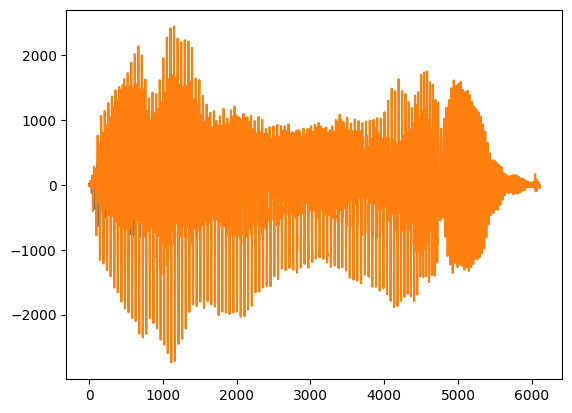

In [3]:
Fe1, s1 = wav.read(file_name(1, 2, 47))
Fe2, s2 = wav.read(file_name(1, 2, 31))
print(f"Fréquence d'échantillonnage : {Fe1}\nSignal échantillonné : {s1}")

plt.plot(s1)
plt.plot(s2)
plt.show()

On cherche à représenter un signal par ses coefficients LPC. Pour cela, on fait glisser une fenêtre sur le signal et, en considérent le signal stationnaire sur cette fenêtre d'une vingtaine de millisecondes, on calcule les coefficients LPC de la fenêtre en résolvant l'équation de Yule-Walker. 

In [4]:
# On définit l'ordre du modèle LPC, c'est à dire le nombre de coefficients calculés à chaque fenêtre
order = 10

In [5]:
from scipy.linalg import toeplitz, inv

def compute_lpc_window(f):
    window_size = len(f)
    R = np.zeros((order+1,1))

    for k in range(order+1):
        R[k] = np.mean(f[0:window_size-1-k] * f[k:window_size-1])
    
    # Système à résoudre
    r_mat = toeplitz(R)
    v = np.zeros((order+1, 1))
    v[0] = 1

    coefs = inv(r_mat).dot(v)
    coefs = coefs / coefs[0]  # On normalise les coefficients par la valeur du premier
    
    return coefs


def compute_lpc(s, Fe):
    # Tailles du signal et de la fenêtre
    signal_size = len(s)
    window_size = int(Fe * 20 / 1000)
    offset = 0
    coefs = np.array([[0]*(order+1)])

    # On parcourt le signal entier
    while offset + window_size <= signal_size:
        f = s[offset:offset + window_size]
        f = f * np.hamming(window_size)  # On atténue les effets de bords

        # Calcul des coefficients de la fenêtre
        lpc_window = compute_lpc_window(f)
        coefs = np.concatenate((coefs, lpc_window.T), 0)

        # On décale la fenêtre actuelle en gardant une superposition pour ne pas perdre d'information
        offset += window_size // 2

    return coefs[1:]

On calcule les coefficients LPC de deux signaux d'exemple.

In [6]:
coefs1 = compute_lpc(s1, Fe1)
coefs2 = compute_lpc(s2, Fe2)

print(coefs1.shape)
print(coefs2.shape)

(26, 11)
(75, 11)


## Calcul des distances
On cherche maintenant à calculer une distance entre 2 signaux de tailles variables. On utilise la distance élastique qui calcule la distance entre 2 entrées de tailles différentes de manière locale. 

In [7]:
# Matrice des distances entre 2 listes de tailles différentes (ici le nombre de fenêtre dans chaque signal) 
# de vecteurs de même taille (ici les coefficients LPC)
def distance_matrix(M1, M2):
    M1_sq_sum = np.sum(M1*M1, axis=1, keepdims=True)
    M2_sq_sum = np.sum(M2*M2, axis=1, keepdims=True)
    product = np.matmul(M1, M2.T)

    dists = np.sqrt(M1_sq_sum + M2_sq_sum.T - 2 * product)
    return dists


# Calcul de la matrice de coût de proche en proche pour donner la distance entre 2 signaux
def cost_matrix(coefs1, coefs2, wv, wd, wh):
    n1, n2 = len(coefs1), len(coefs2)
    cost = np.zeros((n1, n2))
    dist = distance_matrix(coefs1, coefs2)
    cost[0][0] = dist[0][0]

    # Initialisation de la première ligne de la matrice de coût
    for j in range(1, n2):
        cost[0][j] = cost[0][j - 1] + wh * dist[0][j]

    # Initialisation de la première colonne de la matrice de coût
    for i in range(1, n1):
        cost[i][0] = cost[i - 1][0] + wv * dist[i][0]
    
    # Mise à jour de la matrice de coût de proche en proche
    for i in range(1, n1):
        for j in range(1, n2):
            cout_suppression = cost[i - 1][j] + wv * dist[i][j]
            cout_substitution = cost[i - 1][j - 1] + wd * dist[i][j]
            cout_insertion = cost[i][j - 1] + wh * dist[i][j]
            
            cost[i][j] = min(cout_suppression, cout_substitution, cout_insertion)

    return cost / (n1 + n2) # On normalise par la taille des signaux

En reprenant l'exemple des 2 signaux dont on a les coefficients, on peut calculer la matrice de coût et afficher le coût minimal (retenu comme la distance entre les signaux audio).

In [8]:
# Poids associés à chaque transformation
wv, wd, wh = 1, 1, 1

# Exemple de matrice de coût
cost = cost_matrix(coefs1, coefs2, wv, wd, wh)
print(cost)
print(cost[-1][-1])

[[0.02802932 0.03332944 0.04230404 ... 5.44100171 5.47142828 5.48449332]
 [0.05482743 0.03225348 0.03892204 ... 5.44221273 5.47228013 5.48614665]
 [0.077835   0.03524432 0.03551384 ... 5.44162497 5.47630025 5.48965815]
 ...
 [1.4544345  1.19845217 1.19669749 ... 5.40382279 5.41270114 5.44743262]
 [1.49636467 1.21723879 1.21892493 ... 5.27291588 5.2940751  5.30621734]
 [1.53995734 1.23785677 1.24120247 ... 5.27286709 5.29334719 5.30601241]]
5.30601241248833


## Jeux de données
On cherche à diviser l'ensemble de notre base de données de signaux en un jeu d'apprentissage et un jeu de test afin d'entraîner notre modèle KNN. Récupèrons d'abord l'ensemble des signaux ainsi que leurs étiquettes (le chiffre prononcé dans l'enregistrement).

In [400]:
def get_datasets():
    files_LPC = []
    files_labels = []

    for d in digits:
        for s in range(len(speakers)):
            for i in indices:
                name = file_name(d, s, i)
                Fe, signal = wav.read(file_name(d, s, i))
                if s == 1:  # Les audios de Nicolas sont en stéréo
                    signal = signal[:,0]  # On garde uniquement les valeurs du premier canal
                
                coefs = compute_lpc(signal, Fe)
                if len(coefs) > 0:  # Certains signaux sont vides, on ne les prend pas en compte
                    files_LPC.append(coefs)
                    files_labels.append(d)

    return files_LPC, files_labels

In [401]:
# Création de la base de données
data, labels = get_datasets()

/var/folders/0d/zqhnnfhs2gd_w1k8h80_wp5r0000gn/T/ipykernel_81734/3639815539.py:10: WavFileWarning: Chunk (non-data) not understood, skipping it.
  Fe, signal = wav.read(file_name(d, s, i))


On doit maintenant diviser aléatoirement le jeu de données en deux jeux d'apprentissage et de test. La fonction split_data donne deux jeux données divisés aléatoirement alors que la fonction split_data_even donne 2 jeux de données où chaque classe est représentée équitablement. 

In [422]:
def split_data(data, labels, split_factor):
    n = len(data)
    data_train = []
    labels_train = []
    data_test = []
    labels_test = []

    test_indices = random.sample(range(n), int((1 - split_factor) * n))

    for i in range(n):
        if i in test_indices:
            data_test.append(np.array(data[i], dtype= np.int64))
            labels_test.append(np.array(labels[i], dtype= np.int64))
        else:
            data_train.append(np.array(data[i], dtype= np.int64))
            labels_train.append(np.array(labels[i], dtype= np.int64))

    return np.array(data_train), np.array(labels_train), np.array(data_test), np.array(labels_test)


def split_data_even(data, labels, split_factor):
    data_train = np.array([], dtype=np.int64)
    labels_train = np.array([], dtype=np.int64)
    data_test = np.array([], dtype=np.int64)
    labels_test = np.array([], dtype=np.int64)

    data_sorted = [[data[i] for i in range(len(data)) if labels[i] == d] for d in digits]
    labels_sorted = [[i for i in labels if i == d] for d in digits]

    for d in digits:
        dtr, ltr, dte, lte = split_data(data_sorted[d], labels_sorted[d], split_factor)
        data_train = np.concatenate((data_train, dtr))
        labels_train = np.concatenate((labels_train, ltr))
        data_test = np.concatenate((data_test, dte))
        labels_test = np.concatenate((labels_test, lte))

    return data_train, labels_train, data_test, labels_test

In [403]:
# Création des jeux de données d'apprentissage et de test
data_train, labels_train, data_test, labels_test = split_data(data, labels, 0.8)

print(len(data_train), len(labels_train), len(data_test), len(labels_test))
print(np.bincount(labels_test))

1599 1599 399 399
[41 47 38 33 53 40 35 34 39 39]


/var/folders/0d/zqhnnfhs2gd_w1k8h80_wp5r0000gn/T/ipykernel_81734/1777173469.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data_train), np.array(labels_train), np.array(data_test), np.array(labels_test)


## Algorithme des k-plus proches voisins
La reconnaissance vocale se base sur l'algorithme KNN, en considérant les étiquettes des signaux les plus proches de celui à identifier. 

In [441]:
# Calcul de la matrice de distances entre 2 jeux de données de coefficients LPC
def distance_signals(data_train, data_test, wv, wd, wh):
    dists = [[0 for j in range(len(data_train))] for i in range(len(data_test))]
    
    for i in range(len(data_test)):
        for j in range(len(data_train)):
            if i % 10 == 0 and j == 0:
                print("Progression : %2d / %2d" % (i, len(data_test)))
            dists[i][j] = cost_matrix(data_test[i], data_train[j], wv, wd, wh)[-1][-1]
    return dists


# Donne la valeur prédite pour chaque élément de test en tenant compte des K plus proches voisins
def knn_predict(dists, labels_train, k):
    indices_knn = np.argsort(dists, axis=1)[:, :k]
    labels_knn = labels_train[indices_knn]
    predicted_labels = [np.bincount(labels).argmax() for labels in labels_knn]

    return predicted_labels


# Calcul de la matrice de confusion pour chaque classe étant donné les valeurs prédites et les vraies
def confusion_matrix(predictions, labels_test):
    res = [[0] * 4 for i in digits]

    for digit in digits:
        for i in range(len(labels_test)):
            if labels_test[i] == digit:
                if predictions[i] == digit:
                    res[digit][0] += 1
                else:
                    res[digit][3] += 1
            else:
                if predictions[i] == digit:
                    res[digit][1] += 1
                else:
                    res[digit][2] += 1
    return res 


# Calcul de la matrice de condusion pour chaque chiffre étant donné les jeux de données d'apprentissage et de test
def evaluate_knn(dists, labels_train, labels_test, k):
    predictions = knn_predict(dists, labels_train, k)
    confusions = confusion_matrix(predictions, labels_test)
    
    return confusions

On peut calculer un exemple de matrice de confusion pour ces jeux de données.

In [405]:
# Définition du nombre de plus proches voisins à prendre en compte
k = 5

In [406]:
dists = distance_signals(data_train, data_test, wv, wd, wh)

Progress :  0 / 399
Progress : 10 / 399
Progress : 20 / 399
Progress : 30 / 399
Progress : 40 / 399
Progress : 50 / 399
Progress : 60 / 399
Progress : 70 / 399
Progress : 80 / 399
Progress : 90 / 399
Progress : 100 / 399
Progress : 110 / 399
Progress : 120 / 399
Progress : 130 / 399
Progress : 140 / 399
Progress : 150 / 399
Progress : 160 / 399
Progress : 170 / 399
Progress : 180 / 399
Progress : 190 / 399
Progress : 200 / 399
Progress : 210 / 399
Progress : 220 / 399
Progress : 230 / 399
Progress : 240 / 399
Progress : 250 / 399
Progress : 260 / 399
Progress : 270 / 399
Progress : 280 / 399
Progress : 290 / 399
Progress : 300 / 399
Progress : 310 / 399
Progress : 320 / 399
Progress : 330 / 399
Progress : 340 / 399
Progress : 350 / 399
Progress : 360 / 399
Progress : 370 / 399
Progress : 380 / 399
Progress : 390 / 399


In [407]:
confusions = evaluate_knn(dists, labels_train, labels_test, k)

for i in digits:
    print(confusions[i])

[3, 17, 341, 38]
[7, 26, 326, 40]
[17, 98, 263, 21]
[1, 13, 353, 32]
[3, 2, 344, 50]
[7, 32, 327, 33]
[14, 31, 333, 21]
[6, 66, 299, 28]
[4, 41, 319, 35]
[2, 9, 351, 37]


In [408]:
print([sum(confusions[i]) for i in digits])
print([confusions[i][0] for i in digits])
print([confusions[i][0] + confusions[i][3] for i in digits])
print([confusions[i][0] + confusions[i][1] for i in digits])

[399, 399, 399, 399, 399, 399, 399, 399, 399, 399]
[3, 7, 17, 1, 3, 7, 14, 6, 4, 2]
[41, 47, 38, 33, 53, 40, 35, 34, 39, 39]
[20, 33, 115, 14, 5, 39, 45, 72, 45, 11]


## Performances du modèle
À partir des matrices de confusions, on peut calculer le taux de classification, le rappel, la précision et la F-mesure pour chaque chiffre. On prend garde à vérifier que ces valeurs sont bien définies (certains dénominateurs peuvent être nuls lorsque le classifieur n'est pas performant).

In [409]:
def perf_matrix(confusions):
    taux_class = [(conf[0] + conf[2]) / sum(conf) for conf in confusions]
    rappel = [conf[0] / (conf[0] + conf[3]) if conf[0] + conf[3] > 0 else np.NaN for conf in confusions]
    precision = [conf[0] / (conf[0] + conf[1]) if conf[0] + conf[1] > 0 else np.NaN for conf in confusions]
    f_mesure = [2 * rappel[i] * precision[i] / (rappel[i] + precision[i]) if rappel[i] + precision[i] > 0 else np.NaN for conf in confusions]

    return [[taux_class[i], rappel[i], precision[i], f_mesure[i]] for i in digits]

In [432]:
performances = perf_matrix(confusions)

for i in digits:
    print(performances[i])

[0.8621553884711779, 0.07317073170731707, 0.15, 0.08]
[0.8345864661654135, 0.14893617021276595, 0.21212121212121213, 0.08]
[0.7017543859649122, 0.4473684210526316, 0.14782608695652175, 0.08]
[0.8872180451127819, 0.030303030303030304, 0.07142857142857142, 0.08]
[0.8696741854636592, 0.05660377358490566, 0.6, 0.08]
[0.8370927318295739, 0.175, 0.1794871794871795, 0.08]
[0.8696741854636592, 0.4, 0.3111111111111111, 0.08]
[0.7644110275689223, 0.17647058823529413, 0.08333333333333333, 0.08]
[0.8095238095238095, 0.10256410256410256, 0.08888888888888889, 0.08]
[0.8847117794486216, 0.05128205128205128, 0.18181818181818182, 0.08]


On peut afficher les performances du modèle en faisant varier le nombre de voisins considérés.

[0.8290726817042605, 0.8320802005012531, 0.8295739348370927, 0.8325814536340852, 0.8320802005012531, 0.8285714285714286, 0.8280701754385966, 0.8280701754385964, 0.8250626566416039, 0.8250626566416039] [0.15429314448940837, 0.16781075763823577, 0.15184595021361263, 0.1686451456076257, 0.16616988689420986, 0.1488751020959045, 0.1457851994172408, 0.14791389850209968, 0.13265411442652614, 0.13254482625225666] [0.1552506268610849, 0.16122218084904077, 0.1549637055668369, 0.19043277833760508, 0.20260145651449996, 0.17916190960335374, 0.19569065326359375, 0.2442801771871539, nan, nan] [0.21739130434782608, 0.047619047619047616, 0.11764705882352941, 0.0851063829787234, 0.07999999999999999, 0.15384615384615383, 0.0851063829787234, 0.08695652173913042, nan, nan]


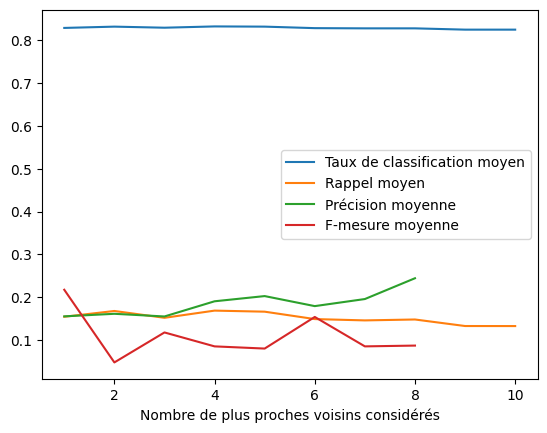

In [442]:
k_range = list(range(1, 11))
tc_moy = []
rappel_moy = []
prec_moy = []
f_mesure_moy = []

for k_neighbors in k_range:
    perfs = perf_matrix(evaluate_knn(dists, labels_train, labels_test, k_neighbors))

    tc_moy.append(np.array([perfs[i][0] for i in digits if perfs[i][0] != np.NaN]).mean())
    rappel_moy.append(np.array([perfs[i][1] for i in digits if perfs[i][1] != np.NaN]).mean())
    prec_moy.append(np.array([perfs[i][2] for i in digits if perfs[i][2] != np.NaN]).mean())
    f_mesure_moy.append(np.array([perfs[i][3] for i in digits if perfs[i][3] != np.NaN]).mean())

print(tc_moy, rappel_moy, prec_moy, f_mesure_moy)

plt.plot(k_range, tc_moy, label="Taux de classification moyen")
plt.plot(k_range, rappel_moy, label="Rappel moyen")
plt.plot(k_range, prec_moy, label="Précision moyenne")
plt.plot(k_range, f_mesure_moy, label="F-mesure moyenne")
plt.xlabel("Nombre de plus proches voisins considérés")
plt.legend()
plt.show()

Ainsi, on voit que le taux de classification reste environ constant aux alentours de 0.8. En revanche, la précision augmente avec le nombre de voisins considérés, contrairement au rappel qui stagne voire diminue un peu. La F-mesure optimale est obtenue avec k = 1 et la seconde valeur est k = 6. En conclusion, selon l'usage, on peut choisir le nombre de voisins qui maximise la mesure la plus appropriée. Les valeurs de rappel et de précision restent très faibles par rapport à l'optimal possible qui est 1. 

On teste aussi le modèle en prenant des jeux d'entrées équitablement répartis entre les classes. 

In [438]:
data_train_even, labels_train_even, data_test_even, labels_test_even = split_data_even(data, labels, 0.8)

print(len(data_train_even), len(labels_train_even), len(data_test_even), len(labels_test_even))
print(np.bincount(labels_test_even))

1608 1608 390 390
[39 39 39 39 39 39 39 39 39 39]


/var/folders/0d/zqhnnfhs2gd_w1k8h80_wp5r0000gn/T/ipykernel_81734/1010074152.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data_train), np.array(labels_train), np.array(data_test), np.array(labels_test)


In [439]:
dists_even = distance_signals(data_train_even, data_test_even, wv, wd, wh)

Progress :  0 / 390
Progress : 10 / 390
Progress : 20 / 390
Progress : 30 / 390
Progress : 40 / 390
Progress : 50 / 390
Progress : 60 / 390
Progress : 70 / 390
Progress : 80 / 390
Progress : 90 / 390
Progress : 100 / 390
Progress : 110 / 390
Progress : 120 / 390
Progress : 130 / 390
Progress : 140 / 390
Progress : 150 / 390
Progress : 160 / 390
Progress : 170 / 390
Progress : 180 / 390
Progress : 190 / 390
Progress : 200 / 390
Progress : 210 / 390
Progress : 220 / 390
Progress : 230 / 390
Progress : 240 / 390
Progress : 250 / 390
Progress : 260 / 390
Progress : 270 / 390
Progress : 280 / 390
Progress : 290 / 390
Progress : 300 / 390
Progress : 310 / 390
Progress : 320 / 390
Progress : 330 / 390
Progress : 340 / 390
Progress : 350 / 390
Progress : 360 / 390
Progress : 370 / 390
Progress : 380 / 390


[0.826153846153846, 0.8282051282051283, 0.8302564102564103, 0.8292307692307691, 0.8246153846153847, 0.8266666666666668, 0.8241025641025642, 0.8225641025641026, 0.8251282051282052, 0.8246153846153847] [0.13076923076923075, 0.14102564102564102, 0.1512820512820513, 0.14615384615384616, 0.12307692307692306, 0.13333333333333333, 0.12051282051282053, 0.11282051282051282, 0.12564102564102564, 0.12307692307692306] [0.17227112542629783, 0.21546653796653797, 0.2380200076500151, 0.12314239230624183, 0.09703588868911449, nan, nan, nan, nan, nan] [0.16666666666666669, 0.09756097560975609, 0.09756097560975609, nan, nan, nan, nan, nan, nan, nan]


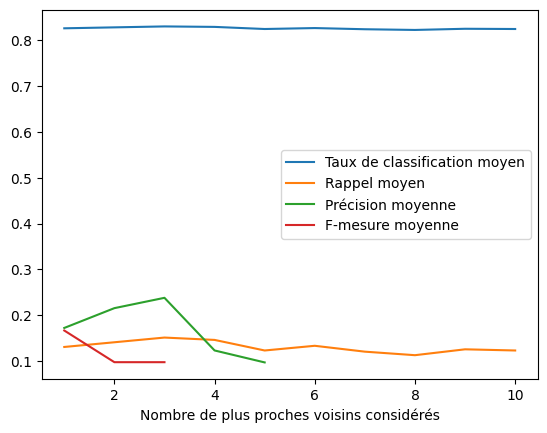

In [440]:
k_range = list(range(1, 11))
tc_moy = []
rappel_moy = []
prec_moy = []
f_mesure_moy = []

for k_neighbors in k_range:
    perfs = perf_matrix(evaluate_knn(dists_even, labels_train_even, labels_test_even, k_neighbors))

    tc_moy.append(np.array([perfs[i][0] for i in digits if perfs[i][0] != np.NaN]).mean())
    rappel_moy.append(np.array([perfs[i][1] for i in digits if perfs[i][1] != np.NaN]).mean())
    prec_moy.append(np.array([perfs[i][2] for i in digits if perfs[i][2] != np.NaN]).mean())
    f_mesure_moy.append(np.array([perfs[i][3] for i in digits if perfs[i][3] != np.NaN]).mean())

print(tc_moy, rappel_moy, prec_moy, f_mesure_moy)

plt.plot(k_range, tc_moy, label="Taux de classification moyen")
plt.plot(k_range, rappel_moy, label="Rappel moyen")
plt.plot(k_range, prec_moy, label="Précision moyenne")
plt.plot(k_range, f_mesure_moy, label="F-mesure moyenne")
plt.xlabel("Nombre de plus proches voisins considérés")
plt.legend()
plt.show()

On remarque tout d'abord que beaucoup de classes ne sont pas représentées dans les statistiques car les performances ne sont pas assez bonnes (un rappel ou une précision non définis empêchent de définir la F-mesure). Le taux de classification est aussi bon avec cette définition des jeux de données d'entraînement et de test. Cependant, le rappel est inférieur au précédent lorsque chaque classe est représentée équitablement dans les jeux de données.

Les poids intervenant dans le calcul de la matrice de coût sont aussi un méta-paramètre déterminant les performances du modèle. On teste plusieurs combinaisons de ces poids pour quantifier leur impact.

Progression :  0 / 399
Progression : 10 / 399
Progression : 20 / 399
Progression : 30 / 399
Progression : 40 / 399
Progression : 50 / 399
Progression : 60 / 399
Progression : 70 / 399
Progression : 80 / 399
Progression : 90 / 399
Progression : 100 / 399
Progression : 110 / 399
Progression : 120 / 399
Progression : 130 / 399
Progression : 140 / 399
Progression : 150 / 399
Progression : 160 / 399
Progression : 170 / 399
Progression : 180 / 399
Progression : 190 / 399
Progression : 200 / 399
Progression : 210 / 399
Progression : 220 / 399
Progression : 230 / 399
Progression : 240 / 399
Progression : 250 / 399
Progression : 260 / 399
Progression : 270 / 399
Progression : 280 / 399
Progression : 290 / 399
Progression : 300 / 399
Progression : 310 / 399
Progression : 320 / 399
Progression : 330 / 399
Progression : 340 / 399
Progression : 350 / 399
Progression : 360 / 399
Progression : 370 / 399
Progression : 380 / 399
Progression : 390 / 399
Progression :  0 / 399
Progression : 10 / 399
Prog

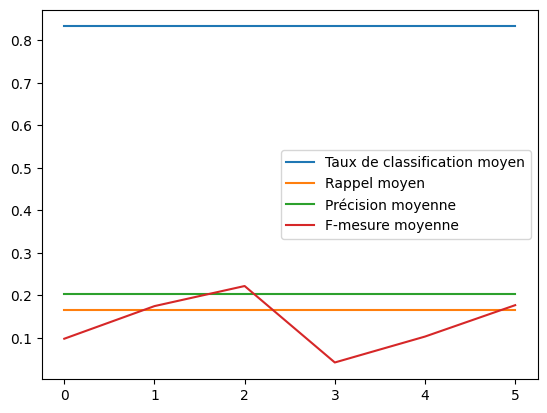

In [444]:
wvs, wds, whs = [0.5, 0.5, 0.75, 0.75, 1, 1], [0.75, 1, 0.5, 1, 0.5, 0.75], [1, 0.75, 1, 0.5, 0.75, 0.5]
tc_moy_test = []
rappel_moy_test = []
prec_moy_test = []
f_mesure_moy_test = []

for i in range(len(wvs)):
    wv_test, wd_test, wh_test = wvs[i], wds[i], whs[i]
    dists_test = distance_signals(data_train, data_test, wv, wd, wh)
    confusion_test = evaluate_knn(dists_test, labels_train, labels_test, k)
    perfs_test = perf_matrix(confusion_test)
    tc_moy_test.append(np.array([perfs_test[i][0] for i in digits if perfs_test[i][0] != np.NaN]).mean())
    rappel_moy_test.append(np.array([perfs_test[i][1] for i in digits if perfs_test[i][1] != np.NaN]).mean())
    prec_moy_test.append(np.array([perfs_test[i][2] for i in digits if perfs_test[i][2] != np.NaN]).mean())
    f_mesure_moy_test.append(np.array([perfs_test[i][3] for i in digits if perfs_test[i][3] != np.NaN]).mean())

print(tc_moy_test, rappel_moy_test, prec_moy_test, f_mesure_moy_test)

plt.plot(list(range(len(wvs))), tc_moy_test, label="Taux de classification moyen")
plt.plot(list(range(len(wvs))), rappel_moy_test, label="Rappel moyen")
plt.plot(list(range(len(wvs))), prec_moy_test, label="Précision moyenne")
plt.plot(list(range(len(wvs))), f_mesure_moy_test, label="F-mesure moyenne")
plt.xlabel("Configuration des poids étudiée")
plt.legend()
plt.show()

![Résultats comparaison](weights_comp.png)

La configuration des poids ne semble pas influencer toutes les mesures de performances du modèle. On remarque cependant que la F-mesure moyenne est meilleure avec les poids wv, wd, wh = 0.75, 0.5, 1, c'est à dire en donnant un coût plus grand à l'insertion qu'à la suppression.
On retente désormais le même test sur des jeux de données de taille inférieure afin de gagner en temps de calcul. Par exemple, on ne considère que les 3 premiers chiffres au lieu de 10.

In [448]:
def get_datasets_short(maxi):
    files_LPC = []
    files_labels = []

    for d in digits[:maxi]:
        for s in range(len(speakers)):
            for i in indices:
                name = file_name(d, s, i)
                Fe, signal = wav.read(file_name(d, s, i))
                if s == 1:  # Les audios de Nicolas sont en stéréo
                    signal = signal[:,0]  # On garde uniquement les valeurs du premier canal
                
                coefs = compute_lpc(signal, Fe)
                if len(coefs) > 0:  # Certains signaux sont vides, on ne les prend pas en compte
                    files_LPC.append(coefs)
                    files_labels.append(d)

    return files_LPC, files_labels

data_short, labels_short = get_datasets_short(3)
short_data_train, short_labels_train, short_data_test, short_labels_test = split_data(data_short, labels_short, 0.8)

/var/folders/0d/zqhnnfhs2gd_w1k8h80_wp5r0000gn/T/ipykernel_81734/2926646287.py:9: WavFileWarning: Chunk (non-data) not understood, skipping it.
  Fe, signal = wav.read(file_name(d, s, i))
/var/folders/0d/zqhnnfhs2gd_w1k8h80_wp5r0000gn/T/ipykernel_81734/1010074152.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data_train), np.array(labels_train), np.array(data_test), np.array(labels_test)


In [450]:
wvs, wds, whs = [0.5, 0.5, 0.75, 0.75, 1, 1], [0.75, 1, 0.5, 1, 0.5, 0.75], [1, 0.75, 1, 0.5, 0.75, 0.5]
tc_moy_test = []
rappel_moy_test = []
prec_moy_test = []
f_mesure_moy_test = []

for i in range(len(wvs)):
    wv_test, wd_test, wh_test = wvs[i], wds[i], whs[i]
    short_dists = distance_signals(short_data_train, short_data_test, wv, wd, wh)
    short_confusions = evaluate_knn(short_dists, short_labels_train, short_labels_test, k)
    short_perfs = perf_matrix(short_confusions)
    tc_moy_test.append(np.array([short_perfs[i][0] for i in digits if short_perfs[i][0] != np.NaN]).mean())
    rappel_moy_test.append(np.array([short_perfs[i][1] for i in digits if short_perfs[i][1] != np.NaN]).mean())
    prec_moy_test.append(np.array([short_perfs[i][2] for i in digits if short_perfs[i][2] != np.NaN]).mean())
    f_mesure_moy_test.append(np.array([short_perfs[i][3] for i in digits if short_perfs[i][3] != np.NaN]).mean())

print(tc_moy_test, rappel_moy_test, prec_moy_test, f_mesure_moy_test)

Progression :  0 / 119
Progression : 10 / 119
Progression : 20 / 119
Progression : 30 / 119
Progression : 40 / 119
Progression : 50 / 119
Progression : 60 / 119
Progression : 70 / 119
Progression : 80 / 119
Progression : 90 / 119
Progression : 100 / 119
Progression : 110 / 119
Progression :  0 / 119
Progression : 10 / 119
Progression : 20 / 119
Progression : 30 / 119
Progression : 40 / 119
Progression : 50 / 119
Progression : 60 / 119
Progression : 70 / 119
Progression : 80 / 119
Progression : 90 / 119
Progression : 100 / 119
Progression : 110 / 119
Progression :  0 / 119
Progression : 10 / 119
Progression : 20 / 119
Progression : 30 / 119
Progression : 40 / 119
Progression : 50 / 119
Progression : 60 / 119
Progression : 70 / 119
Progression : 80 / 119
Progression : 90 / 119
Progression : 100 / 119
Progression : 110 / 119
Progression :  0 / 119
Progression : 10 / 119
Progression : 20 / 119
Progression : 30 / 119
Progression : 40 / 119
Progression : 50 / 119
Progression : 60 / 119
Progr

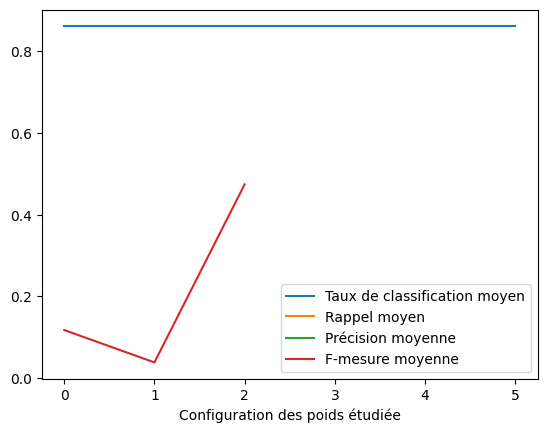

In [451]:
plt.plot(list(range(len(wvs))), tc_moy_test, label="Taux de classification moyen")
plt.plot(list(range(len(wvs))), rappel_moy_test, label="Rappel moyen")
plt.plot(list(range(len(wvs))), prec_moy_test, label="Précision moyenne")
plt.plot(list(range(len(wvs))), f_mesure_moy_test, label="F-mesure moyenne")
plt.xlabel("Configuration des poids étudiée")
plt.legend()
plt.show()

Peu de configurations des poids donnent des résultats performants ou même exploitables. Cependant, c'est encore la configuration wv, wd, wh = 0.75, 0.5, 1 qui apporte les résultats les plus satisfaisants, avec une F-mesure moyenne atteignant 0.5. 